In [30]:
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_addons as tfa
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

from empiricalgalo import utils, models

import joblib

%load_ext autoreload
%autoreload 2


try:
    # Disable all GPUS
    tf.config.set_visible_devices([], 'GPU')
    visible_devices = tf.config.get_visible_devices()
    for device in visible_devices:
        assert device.device_type != 'GPU'
except:
    # Invalid device or cannot modify virtual devices once initialized.
    pass

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load in some data & preprocess

In [4]:
data = np.load("../../data/HAGNmatch.npy")
# Apply cuts
m = (data["H_level"] == 1) & (data["H_mhalo"] > 1e10) & (data["G_mgal"] > 1e9)
data = data[m]


features = ["H_mhalo", "H_concentration", "H_spin"]
# Which features are to be logged
log_features = ["H_mhalo", "H_concentration", "H_spin"]
target = "G_mgal"

# Train-test split
Xtrain, Xtest, ytrain, ytest = utils.stratify_split(data, features, target, target, True)

# Define the feature and target pipeline
features_pipe = Pipeline([('selector', utils.DataFrameSelector(features, log_features)),
                          ('PCA', PCA(whiten=True, n_components=len(features)))])
target_pipe = Pipeline([('selector', utils.DataFrameSelector(target, target))])

# Train the pipeline on the train set and apply to the test set
Xtrain, Xtest = utils.apply_preprocess(Xtrain, Xtest, features_pipe)
ytrain, ytest = utils.apply_preprocess(ytrain, ytest, target_pipe)

# Set up the NN model

In [22]:
# Some checkpointing directory where the models' weights are saved
checkpoint_dir = "./checkpoints"
batch_size = 750

clr = tfa.optimizers.CyclicalLearningRate(initial_learning_rate=0.001,
    maximal_learning_rate=0.01,
    scale_fn=lambda x: 1/(2.**(x-1)),
    step_size=2 * len(ytrain) // batch_size)
optimizer = tf.optimizers.Adamax(learning_rate=clr)
Nensemble = 100

# Create the directories
cdirs = models.make_checkpoint_dirs(checkpoint_dir, Nensemble)

seeds = models.get_random_seeds(Nensemble, 42)

In [23]:
# Directly fit the model and save the weights in the checkpoint folder
# This training is not parallelised on this step as in practise we wish
# to use e.g. MPI.

from tqdm import tqdm

for i in tqdm(range(Nensemble)):
    models.GaussianLossNN.fit_directly(
        Xtrain, ytrain, batch_size, cdirs[i], seeds[i],
        optimizer=optimizer, epochs=1000, patience=75)

100%|█████████████████████████████████████████████████████████████████████████| 100/100 [4:51:48<00:00, 175.09s/it]


# Inspect the NN ensemble

In [24]:
ensemble = models.SummaryEnsembleGaussianLossNN(checkpoint_dir, optimizer)

Found 100 models in `./checkpoints`.


## Plot the $R^2$ and $\chi^2$ of each model in the ensemble

<IPython.core.display.Javascript object>


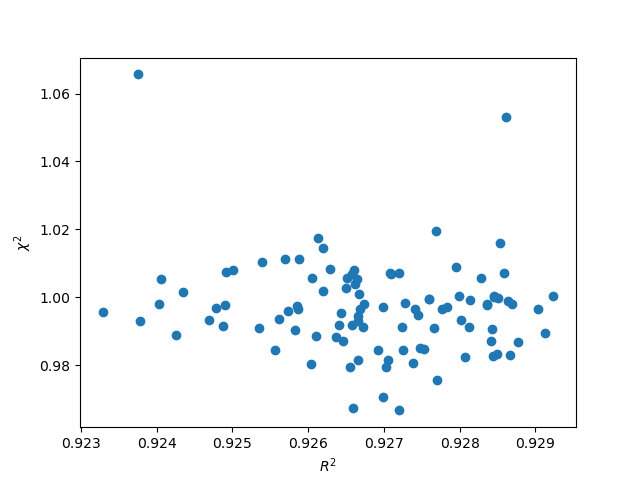

In [32]:
R2 = ensemble.score_R2mean(Xtest, ytest)
chi2 = ensemble.score_reduced_chi2(Xtest, ytest)

plt.figure()
plt.scatter(R2, chi2)
plt.xlabel(r"$R^2$")
plt.ylabel("$\chi^2$")
plt.show()

## The summary $R^2$ and $\chi^2$

In [36]:
R2mean = ensemble.score_R2mean(Xtest, ytest, False)
print("Mean R2 = {}".format(R2mean))
chi2mean = ensemble.score_reduced_chi2(Xtest, ytest, False)
print("Mean chi2 = {}".format(chi2mean))

Mean R2 = 0.9287943576214983
Mean chi2 = 0.9282089277860325


We find that the summary $\chi^2 < 1$, even though the individual $\chi^2 \approx 1$. That is because we stack the 1-dimensional Gaussian distribution. 

## Plot the predictions

<IPython.core.display.Javascript object>


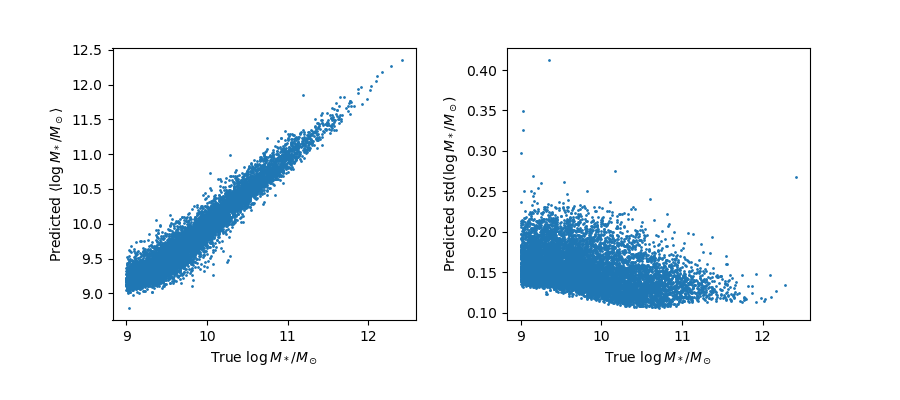

In [67]:
pred = ensemble.predict_summary(Xtest, True)


fig, axes = plt.subplots(ncols=2, figsize=(9, 4))
fig.subplots_adjust(wspace=0.3, bottom=0.2)

axes[0].scatter(ytest, pred[:, 0], s=1)
axes[1].scatter(ytest, pred[:, 1], s=1)

for i in range(2):
    axes[i].set_xlabel(r"True $\log M_* / M_\odot$")

axes[0].set_ylabel(r"Predicted $\langle \log M_* / M_\odot \rangle $")
axes[1].set_ylabel(r"Predicted $\mathrm{std}\left(\log M_* / M_\odot \right) $")

fig.show()

## How much do the predictions from individuals models in the ensemble disagree?

<IPython.core.display.Javascript object>


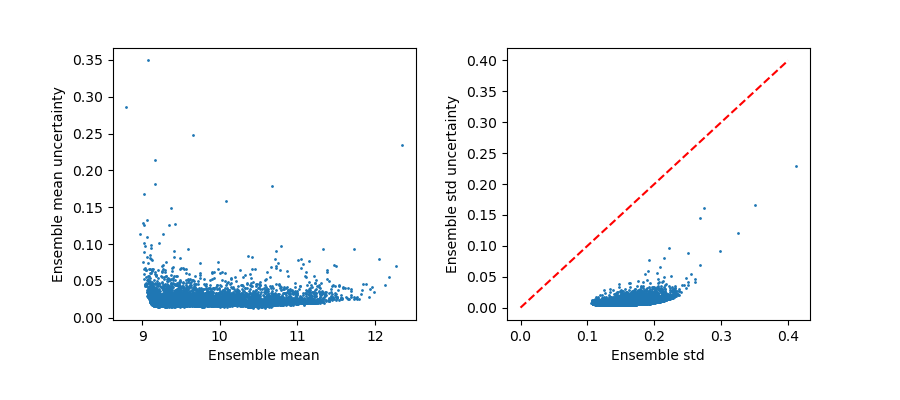

In [74]:
pred = ensemble.predict_summary(Xtest, True, True)

fig, axes = plt.subplots(ncols=2, figsize=(9, 4))
fig.subplots_adjust(wspace=0.3, bottom=0.2)

for i in range(2):
    axes[i].scatter(pred[:, i, 0], pred[:, i, 1], s=1)

t = np.linspace(0, 0.4, 100)
axes[1].plot(t, t, c="red", ls="--")

axes[0].set_xlabel("Ensemble mean")
axes[0].set_ylabel("Ensemble mean uncertainty")

axes[1].set_xlabel("Ensemble std")
axes[1].set_ylabel("Ensemble std uncertainty")

fig.show()